In [2]:
#Set up generating mathematical functions in tree structures from the following
#primitives, these will be used for calculating displacements of neurons
from deap import gp
import operator
import math
def square(x):
    return x*x
def absSqrt(x):
    return math.sqrt(abs(x))
pset = gp.PrimitiveSet("nodePrims", arity=1)
pset.addPrimitive(max, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(math.sin, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(absSqrt, 1)
pset.addPrimitive(square, 1)

gen	nevals	mean   	min	max    	stdDev 
0  	150   	21.7032	1  	1734.14	142.609
1  	21    	153.822	4  	1734.14	451.224
2  	24    	640.798	6.14948	1734.14	803.162
3  	22    	1206.66	36.6039	1734.14	760.815
4  	23    	1697.18	256    	1734.14	230.774
5  	25    	1854.81	1734.14	6561   	753.594
6  	22    	1975.48	1734.14	6561   	1051.99
7  	16    	3182.2 	1734.14	6561   	2211.95
8  	27    	5243.81	1734.14	6561   	2010.34
9  	20    	6561   	6561   	6561   	0      
10 	23    	6561   	6561   	6561   	0      
11 	22    	6561   	6561   	6561   	0      
12 	23    	6561   	6561   	6561   	0      
13 	24    	6561   	6561   	6561   	0      
14 	23    	6561   	6561   	6561   	0      
15 	24    	6561   	6561   	6561   	0      
16 	25    	6561   	6561   	6561   	0      
17 	23    	6561   	6561   	6561   	0      
18 	24    	6561   	6561   	6561   	0      
19 	22    	6561   	6561   	6561   	0      
20 	21    	6561   	6561   	6561   	0      
21 	26    	6561   	6561   	6561   	0      
22 	26    	6561   	6561

<IPython.core.display.Javascript object>


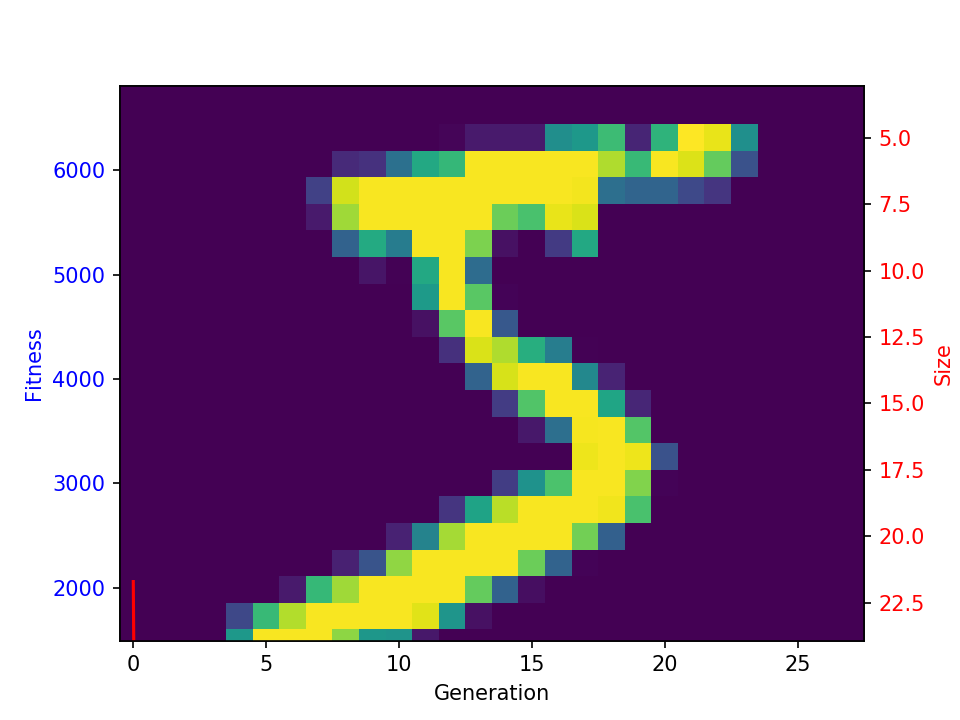

In [13]:
#Code to implement the evolution of the models and hyperparameters for generating them
%matplotlib notebook
from deap import creator, base, tools, algorithms
from random import randint
import numpy as np
import pickle
import itertools
import matplotlib.pyplot as plt
DataDims = 2
MINDIMFUNCS = 1
MAXDIMFUNCS = 10
MINDIMS = DataDims
MAXDIMS = 10
POPSIZE = 150
GENERATIONS = 25
MU = 40
LAMBDA = 30
CXPB = 0.5
MUTPB = 0.3
WEIGHTSCALE = 0.05
BIASSCALE = 0.05


def genTreeList():
    return [gp.PrimitiveTree(gp.genHalfAndHalf(pset=pset, min_=1,max_=6)) for i in range(randint(MINDIMFUNCS,MAXDIMFUNCS))]
def genFuncList():
    return [genTreeList() for j in range(randint(MINDIMS,MAXDIMS))]

creator.create("FitnessMax", base.Fitness, weights=(1.0,) )
creator.create("Individual", list, fitness=creator.FitnessMax)

# def myMutate(individual):
#     new = [[gp.mutNodeReplacement(x,pset=pset) for x in l] for l in toolbox.clone(individual)]
#     return (tools.initIterate(creator.Individual, lambda: new),)


def getFitMap(ls):
    fitnesses = []
    for l in ls:
        fitnesses.append(l.fitness.values[0])
    return fitnesses

def evolve(evaluator):
    
    
    
    creator.create("FitnessMax", base.Fitness, weights=(1.0,) )
    creator.create("Individual", list, fitness=creator.FitnessMax)
    
    toolbox = base.Toolbox()
    toolbox.register("individual", tools.initIterate, creator.Individual, genFuncList)
    
    def myMutate(individual):
        new = [[gp.mutNodeReplacement(x,pset=pset) for x in l] for l in toolbox.clone(individual)]
        new = [[x[0] for x in l] for l in new]
        return (tools.initIterate(creator.Individual, lambda: new),)

    toolbox.register("mate", tools.cxUniform, indpb=0.5)
    toolbox.register("mutate", myMutate)
    toolbox.register("select", tools.selTournament, tournsize = 4)
    toolbox.register("evaluate", evaluator)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    pop = toolbox.population(POPSIZE)
    
    

    myStats = tools.Statistics()
    myStats.register("mean", lambda ls: np.mean(getFitMap(ls)))
    myStats.register("min", lambda ls: min(getFitMap(ls)))
    myStats.register("max", lambda ls: max(getFitMap(ls)))
    myStats.register("stdDev", lambda ls: np.std(getFitMap(ls)))

    hallOFame = tools.HallOfFame(5) # hall of fame of size 5


    (finalPop, logbook) = algorithms.eaMuPlusLambda(pop, toolbox, MU, LAMBDA, CXPB, MUTPB, GENERATIONS, myStats, halloffame=hallOFame, verbose=True)

    gen = logbook.select("gen")
    fit_maxs = logbook.select("max")
    fit_avgs = logbook.select("mean")

    fig, ax1 = plt.subplots()
    line1 = ax1.plot(gen, fit_maxs, "b-", label="Maximum Fitness")
    ax1.set_xlabel("Generation")
    ax1.set_ylabel("Fitness", color="b")
    for tl in ax1.get_yticklabels():
        tl.set_color("b")

    ax2 = ax1.twinx()
    line2 = ax2.plot(gen, fit_avgs, "r-", label="Average Fitness")
    ax2.set_ylabel("Size", color="r")
    for tl in ax2.get_yticklabels():
        tl.set_color("r")

    lns = line1 + line2
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc="center right")

    plt.show()
    
def flatten(mylist):
    return list(itertools.chain.from_iterable(mylist))
    
def myEval(individual):
    funcs = []
    for dimlist in individual:
        newDimlist = []
        for tree in dimlist:
#             print gp.stringify(tree)
            f = gp.compile(tree, pset)
            newDimlist.append(f)
        funcs.append(newDimlist)
    flattened = flatten(funcs)
    mapped = map(lambda f: f(1), flattened)
    return max(mapped),
    
    
evolve(myEval)

In [7]:
#Load MNIST data to train/test models on
import theano
import mnist
import numpy as np

train_images = mnist.train_images()
train_labels = mnist.train_labels()

test_images = mnist.test_images()
test_labels = mnist.test_labels()

Using cuDNN version 7005 on context None
Mapped name None to device cuda: GRID K520 (0000:00:03.0)


In [16]:
#parse mnist data into form that we will use
def labelToArray(x):
    blank = [0] * 10
    blank[x] = 1
    return np.array(blank)

trainingimgs = [train_images[i].astype(theano.config.floatX).ravel() * (1.0/256) for i in range(train_images.shape[0])]
traininglabels = [labelToArray(train_labels[i]).astype(theano.config.floatX) for i in range(train_labels.shape[0])]
testingimgs = [test_images[i].astype(theano.config.floatX).ravel() * (1.0/256) for i in range(test_images.shape[0])]
testinglabels = [labelToArray(test_labels[i]).astype(theano.config.floatX) * (1.0 / 256) for i in range(test_labels.shape[0])]
plt.imshow(trainingimgs[0].reshape(28,28))

In [0]:
#Miscellaneous functions that get used for calculating growth of networks

import theano.tensor as T
from theano import shared
import theano
from autograd import grad as Grad
import autograd.numpy as np
import autograd.numpy.linalg as LA
import itertools
import typing
import time
import math
from itertools import izip
#We're modeling neurons as points in a high dimensional space, but to keep them
#from just going all over the place and not interacting to create interesting 
#structures, we're going to limit the size of that space to a box of this width
SPACESPAN = 2.0

#Take one dimension of a neuron's position -- if it's outside the box,
#wrap it around so it goes in the box. Otherwise, do nothing.
def box(x):
    if x > 0 + SPACESPAN / 2.0:
        return -1.0 + x
    elif x < 0 - SPACESPAN / 2.0:
        return 1.0 + x
    else:
        return x
      
      
#Want neurons that are close together to overlap, so we have a "resolution" of 
#the space such that if neurons are closer than the "resolution", they overlap. 
#resDenominator can be thought of as how many pixels are in a row of the box the
#neurons live in.
def discretize(x, resDenominator):
    if x > 0.0:
        return np.floor(1.0 * x * resDenominator) / resDenominator
    elif x < 0.0:
        return np.floor(1.0 * x * resDenominator) / resDenominator
    else:
        return 0.0
    
def mnistlabelToArray(x):
    blank = [0] * 10
    blank[x] = 1
    return np.array(blank)


def flatten(mylist):
    return list(itertools.chain.from_iterable(mylist))

#Consolidation is strange but crucial. Basically you have a big array of where the
#neurons are in space, then you apply the displacement/"growth" rules to each
#dimension of those positions. Now you have a huge list of neuron positions, and
#consolidating is calculating what neurons overlap, and creating a list of indices
#that tells which neurons are going as input to a neuron in the next layer. You
#could do this with a bitmask, but the networks are usually sparse enough that 
#it would be extremely inefficient, but maybe with a low resDenominator the space
#will overlap enough that it will be efficient. Improving this would be nice, but
#I don't know if its necessary, given this is slow but not terribly slow.

#to be honest I have to look over this a lot too to figure out whats going on.
  
def newSingleGenConsolidate(arrays):
    bigMatrix = np.array(arrays)
    arraylen = len(arrays)
    initArraylen = len(arrays)
    indices = []
    flattenedIndices = []
    
    irange = range(arraylen)
    
    counter = True
    print "starting a singleGenConsolidate"
    for i in irange:
        if i not in flattenedIndices:
            subgroupArr = np.argwhere(np.all((bigMatrix-bigMatrix[i])==0, axis=0))
            subgroup = subgroupArr.tolist()
            indices.append(subgroup)
            flattenedIndices += subgroup
            arraylen -= subgroupArr.size
            if counter and arraylen/initArraylen < 0.5:
                print "half way done a singleGenConsolidate"
                counter = False
    
    print "finished a singleGenConsolidate"
    return indices
            
            
            
def singleGenConsolidate(arrays):
    #takes as input [[position, position,...],[position, position,...], ...]
    #want to find, in the flattened list above, which the indices of all neurons that overlap with the first position,
    #then the indices of all the neurons that overlap with the second position, and so on until done
    
    indices = []
    flattenedIndices = []
    arraylen = len(arrays)
    initArraylen = len(arrays) * 1.0
    irange = range(arraylen)
    
    counter = True
    print "starting a singleGenConsolidate"
    for i in irange:
        if i not in flattenedIndices:
            subgroup = [i] + [j for j in irange[i + 1:] if np.array_equal(arrays[i], arrays[j])]
            arraylen -= len(subgroup)
            indices.append(subgroup)
            flattenedIndices += subgroup
            if counter and arraylen/initArraylen < 0.5:
                print "half way done a singleGenConsolidate"
                counter = False
    
    print "finished a singleGenConsolidate"
    
    #returns a list [[index, index, index,...], [index, index, index,...]] where the ith sublist corresponds to the ith neuron
    #in the next layer up, and each sublist contains the indices of the neurons that connect to them.
    return indices



def nprelu(x):
    np.maximum(0,x)


def getSubV2np(index, inds, complete):
    return complete[inds[index]:inds[index + 1]]

def getSubV3np(index, indinds, inds, complete):
    subInds = inds[indinds[index] : indinds[index + 1] + 1]
    return subInds, complete
  
#this is a consolidation list actually being used
def singleConsol(tensor, indices):
    return (np.choose(indices, tensor)).sum()

def positionConsolidate(arrays, consolidations):
    return [arrays[sublist[0]] for sublist in consolidations]

def numpyConsolidate(array, consols):
    new = []
    for sublist in consols:
        x = 0.0
        for i in sublist:
            x += array[i]
        new.append(x)

    return new

def npConsolidate(array, consolinds, consols):
    ordered = array.take(consols)
    f = lambda i : ordered[consolinds[i]: consolinds[i + 1]].sum()
    veced = np.vectorize(f)
    return veced(np.arange(consolinds.size))


def generalfeedforward((weights, biases, finalweights, finalbiases), consolMasks, hiddenlayers, branchMultiplier, inp):
    #implements a fractalnet in numpy, using consolidation masks instead of lists.
    for i in range(hiddenlayers):
        inp = np.repeat(inp, branchMultiplier)
        inp = np.multiply(weights[i], inp)
        inp = np.concatenate((inp, np.array([0.0]).astype('float32')))
        inp = inp.take(consolMasks[i]).sum(axis = 1)
        inp = nprelu(np.add(inp, biases[i]))
    
    print inp
    finalout = nprelu(np.dot(inp, finalweights) + finalbiases)
    return finalout


class nnet:
    weights = []
    biases = []
    consolidations = []
    finalweights = []
    finalbiases = []
    weightnum = 0
    hiddenlayers = 0
    
    def __init__(self, resolution, functions, inputdimension, datainp, dataoutp, synapseThreshold):
        self.resDenominator = resolution
        self.funcs = functions
        self.dimensions = len(self.funcs)
        
        #branch multiplier says how many neurons grow out of each neuron every
        #time a new layer is grown. This is the same fo
        
        self.branchMultiplier = len(flatten(self.funcs))
        self.TBranchMult = shared(np.array([self.branchMultiplier]))
#         self.dataset = [shared(dat.astype(theano.config.floatX)) for dat in datainp]
#         self.datalabels = [shared(outp.astype(theano.config.floatX)) for outp in dataoutp]
        self.dataSample = datainp[0] #numpy
        self.dataOutSample = dataoutp[0]
        self.inputdimension = inputdimension
        
        if self.dataSample.size ** (1.0/ inputdimension) > self.resDenominator * 2.0:
            print "resDenominator may be too small for effective learning"
            
        self.threshold = synapseThreshold

    def applyFuncs(self, narray): #checked
        #grows a single neuron's new positions, given vector position (represented as a list)
        boxvec = np.vectorize(lambda x: discretize(box(x), self.resDenominator))
        displaced = []
        
        for dim in range(self.dimensions):
            for f in self.funcs[dim]:
                
                zeroes = np.zeros_like(narray)
                displacement = f(narray[dim]) % SPACESPAN
                zeroes[dim] = displacement
                
                newArray = np.add(narray, zeroes)
                newArrayBoxed = boxvec(newArray)
                displaced.append(newArrayBoxed)
                
        
        return displaced
        

    def applyFuncsMult(self, narrays): 
        #given list of neuron positions (lists), grow them and return a list of list of positions, where the first list is the 
        #first neuron's "outgrowths", the second list is the second neuron's "outgrowths" and so on.
        
        return flatten([self.applyFuncs(x) for x in narrays])
    
    def locate(self, sample):  #only 1 or 2 implemented
        #given input data as an array, represent that data spacially as a neurons that can then be grown
        
        insize = sample.size
        sample = np.ravel(sample) 
        tensorFrame = [0] * self.dimensions
        located = [0] * insize
        
        boxvec = np.vectorize(lambda x: discretize(box(x), self.resDenominator))
        
        #self.inputdimension is the dimension the input should be represented in
        
        if self.inputdimension == 1:
            #arrange neurons in a line along the first dimension
            for i in range(insize):
                myTens = tensorFrame[:]
                myTens[0] = (2.0 * i) / insize - 1.0
                located[i] = boxvec(np.array(myTens))
        
        if self.inputdimension == 2:
            #arrange neurons in a grid in the first two dimensions that has integer dimensions, calculated to be as 
            #close to square as possible for convenience
            located = []
            factorPairs = [(i,(insize / i)) for i in range(1, int(math.floor(insize**0.5))) if insize % i == 0]
            pair = factorPairs[-1]
            for i in range(pair[0]):
                for j in range(pair[1]):
                    myTens = tensorFrame[:]
                    myTens[0] = 2.0 * i/pair[0] - 1.0
                    myTens[1] = 2.0 * j/pair[1] - 1.0
                    located.append(boxvec(np.array(myTens)))
                            
        return located
        
    def genConsolidate(self): #finds consolidation list from located self.dataSample
        consols = []
#         print len(self.dataSample.ravel())

        located = self.locate(self.dataSample)
        #type is [position, position, ...], don't care about dataSample's actual values right now, just its dimensions
        
#         print len(located)
#         print type(located[0])
        print "running initial singleGenConsolidate"
    
        #Grow the neurons, generate consolidations list, consolidate, then start a loop
        located = self.applyFuncsMult(located)
        consols.append(singleGenConsolidate(located))
        located = positionConsolidate(located, consols[-1]) 

        
        print "starting to loop"
        #stop the growth when it hits a certain number of weights
        while len(flatten(flatten(consols))) + len(flatten(consols[-1])) * self.branchMultiplier < self.threshold:
            located = self.applyFuncsMult(located)
            testStart = time.time()
            consols.append(singleGenConsolidate(located))
            print "first version took: " + str(time.time() - testStart)
#             testStart = time.time()
#             x = newSingleGenConsolidate(located)
#             print "new version took: " + str(time.time() - testStart)
            
            located = positionConsolidate(located, consols[-1]) 
            print "looped"
            
        self.consolidations = consols
        
        #In contrast to using the consolidation list, which is a list of lists of variable length, you can also pad them to create
        #a list of fixed lengths lists (maximum of the previous variable lengths) that makes things neater but sacrifices some
        #memory (and possibly some speed, but depending on implementation it might be faster). Pad with out of bounds indices
        #that theano and numpy will default to zero.
        self.consolMasks = []
        for layerConsols in self.consolidations:
#             print "initial " + str(layerConsols)
            maxInLength = max(map(len, layerConsols))
            inLength = len(flatten(layerConsols))
            extended = map(lambda l: l + [inLength] * (maxInLength - len(l)), layerConsols)
#             print "extended: " + str(extended)
            self.consolMasks.append(np.array(extended).astype('int32'))
        return consols
    
    def genWeights(self):
        myWeightNum = 0
        self.hiddenlayers = 0
        self.weights = []
        self.biases = []
        self.finalweights = []
        self.finalbiases = []
        for consol in self.consolidations:
            weightVec = (np.random.rand(len(flatten(consol))) * WEIGHTSCALE).astype(theano.config.floatX).tolist()
            biasVec   = (np.random.rand(len(consol)) * BIASSCALE).astype(theano.config.floatX).tolist()
            self.weights.append(weightVec)
            self.biases.append(biasVec)
            myWeightNum += len(weightVec)

            #convert to shared data type for later speed
            self.hiddenlayers += 1
        
        outsize = len(self.dataOutSample)
        
        self.finalweights = np.random.rand(len(self.consolidations[-1]),outsize).astype('float32')        #final interconnected layer for output
        self.finalbiases = np.random.rand(outsize).astype('float32')

        myWeightNum += len(self.consolidations[-1]) * outsize
#         self.weightNum = myWeightNum
        
    def feedforward(self, inp):
        
        for i in range(self.hiddenlayers):
            inp = np.repeat(inp, self.branchMultiplier)
#             print "repeated: " + str(inp)
            inp = np.multiply(self.weights[i], inp)
#             print "weighted: " + str(inp)
            inp = numpyConsolidate(inp, self.consolidations[i])
#             print "consolidated: " + str(inp)
            inp = np.maximum(0, np.add(inp, self.biases[i]))
            print "biased and relued: " + str(inp)
        
#         print "before finals: " + str(inp)
#         print "finalweights: " + str(self.finalweights)
#         print "finalbiases: " + str(self.finalbiases)
        finalout = (np.dot(inp, self.finalweights) + self.finalbiases)
#         print "final: " + str(finalout)
        return finalout

    def nfeedforward(self, inp):
        for i in range(self.hiddenlayers):
            inp = np.repeat(inp, self.branchMultiplier)
            inp = np.multiply(self.weights[i], inp)
            inp = np.concatenate((inp, np.array([0.0]).astype('float32')))
            inp = inp.take(self.consolMasks[i]).sum(axis = 1)
            inp = np.maximum(0,np.add(inp, self.biases[i])))
        return np.dot(inp, self.finalweights) + self.finalbiases
    
    def test(inputs, outputs):
        
        def foo(x):
            if x > 0.5:
                return 1.0
            return 0.0

        binarize = np.vectorize(foo)
        
        errors = [LA.norm(outp - binarize(self.feedforward(inp))) for inp,outp in izip(inputs,outputs)]
        return sum(errors)/len(inputs) * 100.0
        
    
    def numpytrain(self, alpha, epochs, batchsize, inputlist, outputlist, verbose, testdatainputs, testdatalabels):
        print "starting training"
        
        def error((weights, biases, finalweights, finalbiases), inp, outp):
            return LA.norm(outp - generalfeedforward((weights,biases,finalweights,finalbiases), 
                                                     self.consolMasks, self.hiddenlayers, self.branchMultiplier, inp))
        #use autograd to automatically differentiate error function
        error_grad = Grad(error)
        
        inlen = len(inputlist)
        outlen = len(outputlist)

        if inlen != outlen:
            Exception("number of input vectors ("+str(inlen)+") not equal not number of ouptut vectors ("+str(outlen)+")")
            
        if alpha == 0.0:
            raise("why is alpha zero?")
            
        if type(batchsize) != int:
            raise("Why is batchsize not an int?")
        
        if batchsize == 0 or batchsize > inlen:
            raise("batchsize of "+str(batchsize)+"is not allowed. Note than inputveclist has length "+str(inlen))
            
        #just some error checks
        
        randindexlist = range(inlen)
        start = time.time()
        avgpercenttesterror = "No test set"
        avgpercenttesterrorlist = []
        
        #using stochastic gradient descent training method
        for epoch in xrange(epochs):
            #random.shuffle(randindexlist)
            #for batch in range(inlen/batchsize):
            
#                 low = batch * batchsize
#                 upper = (batch + 1) * batchsize
#                 if upper > inlen: upper = inlen 
                
#                 total_Egradweights = None
#                 total_Egradbiases = None
                
#                 for i in randindexlist[low:upper]:
            for inp,outp in izip(inputlist,outputlist):
                Egradws, Egradbs, Egadfws, Egradfbs = error_grad((self.weights, self.biases, 
                                                       self.finalweights, self.finalbiases), inp, outp) #formerly used indexes from randindexlist
#                     if total_Egradweights:
#                         total_Egradweights = [x + y for x,y in izip(Egradweights,total_Egradweights)]
#                         total_Egradbiases = [x + y for x,y in izip(Egradbiases,total_Egradbiases)]
#                     else:
#                         total_Egradweights = Egradweights
#                         total_Egradbiases = Egradbiases
                
#                 total_Egradweights = [x / (batchsize * 1.0) for x in total_Egradweights]
#                 total_Egradbiases = [x / (batchsize * 1.0) for x in total_Egradbiases]
                
#                 self.weights = [curr-grad*alpha for curr, grad in izip(self.weights, total_Egradweights)]
#                 self.biases = [curr-grad*alpha for curr, grad in izip(self.biases, total_Egradbiases)]
                self.weights = [curr-grad*alpha for curr, grad in izip(self.weights, Egradws)]
                self.biases = [curr-grad*alpha for curr, grad in izip(self.biases, Egradbs)]
                self.finalweights = self.finalweights - alpha * Egradfws
                self.finalbiases = self.finalbiases - alpha * Egradfbs
            
            if len(testinputlist) == len(testoutputlist) and len(testinputlist) != 0:
                avgpercenttesterror = self.test(testinputlist, testoutputlist)
                avgpercenttesterrorlist.append(avgpercenttesterror)
            else:
                print "bad test set"
            
            elapsed = time.time() - start
            start = time.time()
            if verbose:
                print "epoch: " + str(epoch) + "\t percenterror: " + str(avgpercenttesterror) + "% \t time elapsed this epoch: " + str(elapsed) + "s"
            
        return (avgpercenttesterror, avgpercenttesterrorlist)

# singleGenConsolidate([np.array([0,0,0]), np.array([0,1,2,3]), np.array([0,0,0])])
testnet = nnet(10, [[lambda x: x + 1], [lambda x: x * 2]], 1, [np.array([0,1,2,3])], [np.array([1])], 100)
testnet.genConsolidate()
testnet.genWeights()
numpyConsolidate(np.array([1,2,3]), [[0,2], [1]])
print testnet.nfeedforward(np.array([0,1,2,3]))
print testnet.feedforward(np.array([0,1,2,3]))
# print mynet.consolidations
        
        
        


running initial singleGenConsolidate
starting a singleGenConsolidate
half way done a singleGenConsolidate
finished a singleGenConsolidate
starting to loop
starting a singleGenConsolidate
half way done a singleGenConsolidate
finished a singleGenConsolidate
first version took: 0.000173807144165
looped
starting a singleGenConsolidate
half way done a singleGenConsolidate
finished a singleGenConsolidate
first version took: 0.0001540184021
looped
starting a singleGenConsolidate
half way done a singleGenConsolidate
finished a singleGenConsolidate
first version took: 0.000154972076416
looped
starting a singleGenConsolidate
half way done a singleGenConsolidate
finished a singleGenConsolidate
first version took: 0.000158071517944
looped
starting a singleGenConsolidate
half way done a singleGenConsolidate
finished a singleGenConsolidate
first version took: 0.000166177749634
looped
starting a singleGenConsolidate
half way done a singleGenConsolidate
finished a singleGenConsolidate
first version to

In [ ]:
import theano
from theano import shared,config,function
import itertools
import theano.tensor as T
import numpy as np
from collections import OrderedDict

# theano.config.exception_verbosity = "high"

def flatten(mylist):
    return list(itertools.chain.from_iterable(mylist))
  


class V2IndexedShared:
    def __init__(self, atype):
        self.myType = atype
    
    def fromList(self,D2List):
        self.complete = shared(np.array(flatten(D2List)).astype(self.myType))
        self.length = shared(len(D2List))
        inds = [0]
        for sublist in D2List:
            inds.append(len(sublist) + inds[-1])
        self.inds = shared(np.array(inds).astype('int32'))
        return self

    
class V3IndexedShared:
    def __init__(self,D3List, atype):
        self.complete = shared(np.array(flatten(flatten(D3List))).astype(atype))
#         self.complete = np.array(flatten(flatten(D3List))).astype(atype)

        self.myType = atype
        self.length = shared(len(D3List))
        D2Inds = [0]
        D3Inds = [0]
        
        for sublistOLists in D3List:
            
            for sublist in sublistOLists:
                D2Inds.append(len(sublist) + D2Inds[-1])
                
            D3Inds.append(len(sublistOLists) + D3Inds[-1])
            
                
        self.D2Inds = shared(np.array(D2Inds).astype('int32'))
        self.D3Inds = shared(np.array(D3Inds).astype('int32'))
        
#         self.D2Inds = np.array(D2Inds).astype('int32')
#         self.D3Inds = np.array(D3Inds).astype('int32')
#         print D3Inds
#         print D2Inds
#         print np.array(flatten(flatten(D3List)))
    

def relu(x):
    return T.maximum(x, 0)

#instead of having nested lists of variable sizes, the following two classes implement either a list of lists and a lists of 
#lists of lists. It implements it by having a "complete" array, then a array of indexes for the beginning and end of the slices
#of that array, then an array for the beginning and end of slices (of the slices array)


def getSubV2(index, inds, complete):
    return complete[inds[index]:inds[index + 1]]

def getSubV2Check():
    tind = T.iscalar('ind')
    tinds = T.ivector('inds')
    tcomp = T.vector('complete')
    
    nind = np.asscalar(np.array([0]).astype('int32'))
    ninds = np.array([0,2,4]).astype('int32')
    comp = np.array([0,1,2,3,4]).astype(theano.config.floatX)
    
    f = theano.function([tind, tinds, tcomp], getSubV2(tind, tinds, tcomp))
    print f(nind,ninds,comp)
getSubV2Check()
def getV2Length(inds):
    return inds.size -1

def getSubV3(index, indinds, inds, complete):
    subInds = inds[indinds[index] : indinds[index + 1] + 1]
    return subInds, complete

def getSubV3Check():
    D3List = [[[0,1,2,], [3,4,5]], [[6,7,8], [9,10,11]]]
    consolcomplete = [0,1,2,3,4,5,6,7,8,9,10,11]
    consolinds = [0,3,6,9,12]
    consolindinds = [0,2,4]
    print getSubV3(1, consolindinds, consolinds, consolcomplete)
    print consolinds[2:5]
    t = V3IndexedShared(D3List, 'int32')
    
# getSubV3Check()

#the following pair of functions implements consolidation of a tensor using theano scan -- not the fastest, but its inherently
#difficult to vectorize.
def singleConsol(tensor, indices):
    return (T.choose(indices, tensor)).sum()

def consolidateTensor(tensor, consolinds, consolcomplete):
    irange = T.arange(getV2Length(consolinds))
    consolidated, updates = theano.scan(fn = lambda ind, tens, coninds, concomp: singleConsol(tens, getSubV2(ind, coninds, concomp)),
                                        sequences = irange,
                                        non_sequences=[tensor, consolinds, consolcomplete])
    return consolidated

def consolidateTensorCheck():
    x = T.vector('x')
    inds = T.ivector('inds')
    complete = T.ivector('complete')
    y = consolidateTensor(x,inds,complete)
    f = theano.function([x,inds,complete], y)
    print f(np.array([1.0,2.0,4.0,8.0]).astype(theano.config.floatX), np.array([0,3,4]).astype('int32'), np.array([1,2,3,0]).astype('int32'))

In [0]:
#this class is essentially the same as nnet above, except that I implemented it in Theano for speed. All of the derivatives are 
#explicitly calculated, as I wasn't able to get theano to differentiate it. A lot of the set up is actually accomplished by the 
#previous class that used numpy.
    
from random import shuffle

class tnnet:
    def __init__(self, resolution, functions, inputdimension, traindatainps, traindataoutps, testdatainps, testdataoutps, synapseThreshold, net = None):
        
        mynet = None
        if net == None:
            mynet = nnet(resolution, functions, inputdimension, traindatainps, traindataoutps, synapseThreshold)
            mynet.genConsolidate()
            mynet.genWeights()
        else:
            mynet = net
        self.nnet = mynet
        

        self.sharedTrainingInps = shared(np.array(traindatainps).astype(theano.config.floatX))
        self.sharedTrainingOutps = shared(np.array(traindataoutps).astype(theano.config.floatX))
        self.sharedTestingInps = shared(np.array(testdatainps).astype(theano.config.floatX))
        self.sharedTestingOutps = shared(np.array(testdataoutps).astype(theano.config.floatX))


#         print "weights: " + str(mynet.weights)
#         print "biases: " + str(mynet.biases)
#         print mynet.feedforward(np.array([0,1,2,3]).astype(theano.config.floatX))
#         inp_lengths = [len(consol) for consol in mynet.consolidations]
#         inp_lengths = [datainps[0].size] + inp_lengths
#         self.inp_lengths = np.array(inp_lengths).astype('int32')
#         print "inp_lengths: " + str(inp_lengths)
#         print "dinp length: " + str(datainps[0].size)
#         print "consolidations: " + str(mynet.consolidations)
        
#         self.maxInp = np.amax(inp_lengths)
#         self.maxPad = shared(np.array([0] * (np.amax(inp_lengths) - min(inp_lengths))).astype(theano.config.floatX))
#         self.maxZeroes = shared(np.array([0.0] * self.maxInp).astype(theano.config.floatX))
        
#         initialPaddingLength = np.amax(inp_lengths) - datainps[0].size
#         self.initialPadding = shared(np.array([0.0] * initialPaddingLength).astype(theano.config.floatX))
#         self.inp_lengths = shared(self.inp_lengths)
        
        tweights = V2IndexedShared(theano.config.floatX)
        tweights.fromList(mynet.weights)
        self.weights = map(lambda x: shared(np.array(x).astype(theano.config.floatX)), mynet.weights)
        
        tbiases = V2IndexedShared(theano.config.floatX)
        tbiases.fromList(mynet.biases)
#         print tbiases.complete.get_value()
        self.biases = map(lambda x: shared(np.array(x).astype(theano.config.floatX)), mynet.biases)
    
        tcons = V3IndexedShared(mynet.consolidations, 'int32')
#         print "final weights: " + str(mynet.finalweights)
        tfws = shared((mynet.finalweights).astype(theano.config.floatX))
        tfbs = shared((mynet.finalbiases).astype(theano.config.floatX))
        self.weightnum = mynet.weightnum
        self.hiddenlayers = mynet.hiddenlayers
        
        self.consolMasks = []
        self.dEdWsinverseConsols = []
        self.oneMultipliers = []
        
        #this loop fulfills two important functions. First, it makes consolmasks from consolidation lists
        #Second, it creates inverse consolidation lists, going from the next layer back to the original layer,
        #which is crucial for backpropagation.
        for layerConsols in mynet.consolidations:
#             print "initial " + str(layerConsols)
            maxInLength = max(map(len, layerConsols))
            inLength = len(flatten(layerConsols))
            extended = map(lambda l: l + [inLength] * (maxInLength - len(l)), layerConsols)
#             print "extended: " + str(extended)
            self.consolMasks.append(shared(np.array(extended).astype('int32')))
            self.oneMultipliers.append(shared(np.array([1.0] * maxInLength).astype(theano.config.floatX)))
            
            flattened = flatten(layerConsols)
            frame = [0] * len(flattened)
            for i in range(len(layerConsols)):
                for sub in layerConsols[i]:
                    frame[sub] = i
            
            self.dEdWsinverseConsols.append(shared(np.array(frame).astype('int32')))
        
#         print self.nnet.consolidations[0]
#         print self.dEdWsinverseConsols[0].get_value()
            
        
        
        inp = T.fvector('inp')
#         paddedInp = T.concatenate([inp, self.initialPadding])
        actualOutp = T.fvector('actualOutp')
        alpha = T.fscalar('alpha')
        
        self.consolidations = map(lambda x: V2IndexedShared('int32').fromList(x), self.nnet.consolidations)
        
        self.winds = tweights.inds
        self.ws = tweights.complete
        self.binds = tbiases.inds
        self.bs = tbiases.complete
        self.consindinds = tcons.D3Inds
        self.consinds = tcons.D2Inds
        self.cons = tcons.complete
        self.bMult = shared(np.asscalar(np.array([mynet.branchMultiplier]).astype('int32')))
        self.fws = tfws
        self.fbs = tfbs
#         print "weights: " + '\n'.join(map(str, self.nnet.weights))
# #         print self.nnet.biases
#         print "inverse Consols: " + '\n'.join(map(lambda x: str(x.get_value().tolist()), self.dEdWsinverseConsols))
#         print "consols: " + '\n'.join(map(str, self.nnet.consolidations))
        self.zeropad = shared(np.array([0.0]).astype(theano.config.floatX))
        
        self.bMultOnes = shared(np.array([1.0] * self.nnet.branchMultiplier).astype(theano.config.floatX))
        
        self.params = self.weights + self.biases + [self.fws, self.fbs]
#         self.constparams = [self.consindinds, self.consinds, self.cons, self.winds, self.binds, self.bMult]
        
#         def singleCons(consInds, tens):
#             asum, _ = theano.scan(fn = lambda i, tensor: tensor[i],
#                                  sequences = consInds,
#                                  non_sequences = tens)
#             return asum.sum()
        
        
#         def layer(ind, inpLength, inp):
#             weights = getSubV2(ind, self.winds, self.ws)
#             biases = getSubV2(ind, self.binds, self.bs)
#             consolinds, consols = getSubV3(ind, self.consindinds, self.consinds, self.cons)
#             inp = T.repeat(inp[0:inpLength], self.bMult)
#             inp = weights * inp
            
#             #consolidation code
#             numConsolidatedRange = T.arange(consolinds.size - 1)
#             inp, _ = theano.scan(fn = lambda ind, x, coninds, concomp: singleCons(getSubV2(ind, coninds, concomp), x),
#                                                 sequences = numConsolidatedRange,
#                                                 non_sequences=[inp, consolinds, consols])
#             inp = inp + biases
#             inp = relu(inp)
#             padding = self.maxPad[0 : self.maxInp - inp.size]
#             inp = T.concatenate([inp, padding])
#             return inp
       
        def layer(ind, x):
            #get output of layer ind with input x
            
#             print "in layer"
#             consolinds = self.consolidations[ind].inds
#             consols = self.consolidations[ind].complete
            
            x = T.repeat(x, self.bMult) * self.weights[ind]
            x = T.concatenate([x, T.zeros_like(x)])
            x = (x.take(self.consolMasks[ind]).astype(theano.config.floatX)) #.sum(axis = 1)
            x = T.dot(x, self.oneMultipliers[ind])
# #             inp, _ = theano.map(fn = lambda i: inp[i],
# #                                sequences = consols)
# #             #consolidation code
#             r = T.arange(consolinds.size - 1).astype(theano.config.floatX)
#             for i in xrange(len(self.nnet.consolidations[ind])):
#                 r = T.set_subtensor(r[i], x[consolinds[i]:consolinds[i + 1]].sum())
#             numConsolidatedRange = T.arange(consolinds.size - 1).astype('int32')
# #             inp2, _ = theano.map(fn = lambda i: inp1[consolinds[i]: consolinds[i + 1]].sum(),
# #                                                 sequences = numConsolidatedRange)
#             r, _ = theano.map(fn = lambda i, x: x[consolinds[i]: consolinds[i+1]].sum(),
#                                                 sequences = numConsolidatedRange,
#                                                 non_sequences=[x])
            return theano.tensor.nnet.relu(x + self.biases[ind])
#             return r

        def gradLayer(ind, nextdEdInputs, layerOutput): #returns (dEdWs, dEdBs, newdEdInputs)
            expandedLayerOutput = T.repeat(layerOutput, self.bMult)
            inverse = self.dEdWsinverseConsols[ind]
            inverseddEdInputs = nextdEdInputs.take(inverse)
            dEdWs = expandedLayerOutput * inverseddEdInputs
            dEdBs = nextdEdInputs
            #upt to here correct
            
            dOutsdIns = T.gt(layerOutput, T.zeros_like(layerOutput))
            dOutsdIns = T.cast(dOutsdIns, 'float32')
            
            dEdConnections = self.weights[ind] * inverseddEdInputs
            dEdConnectionGroups = dEdConnections.reshape((dEdConnections.size // self.bMult, self.bMult))
            dEdOuts = T.dot(dEdConnectionGroups, self.bMultOnes) #could need to be axis 1
            
            newdEdInputs = dEdOuts * dOutsdIns
            
            return (dEdWs, dEdBs, newdEdInputs)
        
        def intermediateLoop(z):
            ret = []
            for i in range(self.hiddenlayers):
                z = layer(i, z)
                ret.append(z.copy())
            
            return ret
        
        def gradLoop(dEdIn, layerOutputs):
            dEdWs = []
            dEdBs = []
            for k in reversed(range(self.hiddenlayers)):
                newdEdWs, newdEdBs, dEdIn = gradLayer(k, dEdIn, layerOutputs[k])
                dEdWs.append(newdEdWs)
                dEdBs.append(newdEdBs)
            
            return dEdWs, dEdBs
        
        def myGrad(theta, actualOutp):
            #get gradient given input (theta) and the target output (actualOutp)
            
            #get all layer outputs
            outputs = intermediateLoop(theta)
            
            #list of all outputs, including input layer "outputs"
            outputs = [theta] + outputs
            
            #calculate final output
            last = T.dot(outputs[-1], self.fws)
            last = last + self.fbs
            last = theano.tensor.nnet.relu(last)
            
            #get error
            difference = last - actualOutp
            err = T.dot(difference, difference)
            
            #get final layer derivative
            finaldOutdIn = T.gt(last, T.zeros_like(last))
            finaldOutdIn = T.cast(finaldOutdIn, 'float32')
            
            #get derivative of error with respect to last layer inputs
            initdEdIn = finaldOutdIn * (last - actualOutp)
            dEdFbs = initdEdIn   
            
            
            initdEdInshuffled = initdEdIn.dimshuffle(('x',0))
            finalStructuredLayerOut = outputs[-1]
            finalStructuredLayerOutShuffled = finalStructuredLayerOut.dimshuffle((0,'x'))
            
            dEdFws = finalStructuredLayerOutShuffled * initdEdInshuffled
            
            
            finalStructuredLayerdOutdIn = T.gt(finalStructuredLayerOut, T.zeros_like(finalStructuredLayerOut))
            finalStructuredLayerdOutdIn = T.cast(finalStructuredLayerdOutdIn, 'float32')
            
            finalStructuredLayerdEdOut = T.dot(initdEdIn, self.fws.T)
            
            finalStructuredLayerdEdIn = finalStructuredLayerdOutdIn * finalStructuredLayerdEdOut
            #up to here is correct

            dEdWs, dEdBs = gradLoop(finalStructuredLayerdEdIn, outputs)
            
            return err, list(reversed(dEdWs)), list(reversed(dEdBs)), dEdFws, dEdFbs #, list(reversed(dEdIns)),
            
            
        final = T.fvector()
        def loop(z):
            ret = T.fvector()
            for i in range(self.hiddenlayers):
                z = layer(i, z)
                ret = z
            return ret
        finalHiddenOutput = loop(inp)
        final = T.dot(finalHiddenOutput, self.fws)
        final = final + self.fbs
        final = theano.tensor.nnet.relu(final)
        
        #Declare theano functions for full classifaction (including end relu linerar classifier)
        self.classify = theano.function([inp], final)
        self.partialClassify = theano.function([inp], finalHiddenOutput)
        
        self.partialClassifyTraining = theano.function(inputs= [index], outputs = finalHiddenOutput,
                                                       givens = {
                                                                        inp : self.sharedTrainingInps[index],
                                                                    } )
        self.partialClassifyTesting = theano.function(inputs=[index], outputs = finalHiddenOutput,
                                                     givens = {
                                                         inp : self.sharedTestingInps[index]
                                                     })
        
        diff = final - actualOutp
        squared = 0.5 * T.dot(diff, diff)

#         print self.classify(np.array([0,1,2,3]).astype(theano.config.floatX))

        index = T.iscalar()

        squaredError, wgrads, bgrads, fwsgrads, fbsgrads = myGrad(inp, actualOutp)
#         mygradients = myGrad(inp, actualOutp)
        self.realGrad = theano.function(inputs = [inp, actualOutp], outputs = T.grad(squared, self.weights))
        self.mygrads = theano.function(inputs = [inp, actualOutp], outputs = wgrads)
        
        #concatenate lists of the gradients so as to iteratively modify them -- don't worry, I'm not just adding them together
        gradients = wgrads + bgrads + [fwsgrads, fbsgrads]
        
#         realgrads = T.grad(squared, self.params)
#         realUpdates = OrderedDict((p, p - alpha * g) for p, g in zip(self.params, realgrads))
        param_Updates = OrderedDict((p, p - alpha * g) for p, g in zip(self.params, gradients))
        
        self.intermediates = theano.function([inp], intermediateLoop(inp))
        
        self.train = theano.function(inputs = [index, alpha],
                                                                    outputs = squaredError,
                                                                    updates = param_Updates,
                                                                    givens = {
                                                                        inp : self.sharedTrainingInps[index],
                                                                        actualOutp: self.sharedTrainingOutps[index]
                                                                    })
#         self.realtrain = theano.function(inputs = [index, alpha],
#                                                                     outputs = squared,
#                                                                     updates = realUpdates,
#                                                                     givens = {
#                                                                         inp : self.sharedTrainingInps[index],
#                                                                         actualOutp: self.sharedTrainingOutps[index]
#                                                                     })
        self.test = theano.function(inputs = [index],
            outputs = final,
            givens = {
                inp : self.sharedTestingInps[index]
            })
    
    def descend(self, alpha, epochs, trainingInps, trainingOutps, testingInps, testingOutps, verbose):
        training = zip(trainingInps, trainingOutps)
        testing = zip(testingInps, testingOutps)
        testLen = len(testing)
        trainLen = len(trainingInps)
        indorder = range(trainLen)
        testingAccuracies = []
        
        for i in range(epochs):
            print "starting epoch..."
            start = time.time()
            shuffle(indorder)
            for j in indorder:
                self.train(j, alpha)
            
            testingAccuracy = 0.0
            for j in range(len(testingOutps)):
                if np.argmax(self.test(j)) == np.argmax(testingOutps[j]):
                    testingAccuracy += 1.0
            # for (testInp, testOutp) in testing:
            #     if np.argmax(self.classify(testInp)) == np.argmax(testOutp):
            #         testingAccuracy += 1.0
                    
            percentTestingAccuracy = testingAccuracy / testLen * 100.0
            testingAccuracies.append(percentTestingAccuracy)
            end = time.time()
            if verbose:
                print "epoch " + str(i + 1) + " -- testing accuracy : " + str(percentTestingAccuracy) + " duration: " + str(end - start) + "s"
        
        return max(testingAccuracies), testingAccuracies
            
        
tn = tnnet(10, [[lambda x: x + 1], [lambda x: x * 2]], 1, [np.array([0,1,2,3])], [np.array([1,2,3,4])],  [np.array([1,2,3,4])],  [np.array([1,2,3,4])], 100)
print tn.nnet.feedforward(np.array([0,1,2,3]))
print tn.intermediates(np.array([0,1,2,3]).astype(theano.config.floatX))
# print tn.nnet.weights
# print tn.nnet.biases
x = np.array([0,1,2,3]).astype(theano.config.floatX)
classed = tn.classify(np.array([0,1,2,3]).astype(theano.config.floatX))
# print '\n'.join(map(str,classed))
# diff = x * 0.5 - classed
# print np.dot(diff, diff)
# print tn.classify(np.array([0,1,2,3]).astype(theano.config.floatX))
print '\n'.join(map(str, tn.realGrad(x, x * 0.33)))
print '\n'.join(map(str, tn.mygrads(x, x*0.33)))
map(type, tn.mygrads(x, x * 0.33))

[ 0.  1.]
running initial singleGenConsolidate
starting a singleGenConsolidate
half way done a singleGenConsolidate
finished a singleGenConsolidate
starting to loop
starting a singleGenConsolidate
half way done a singleGenConsolidate
finished a singleGenConsolidate
first version took: 0.000130176544189
looped
starting a singleGenConsolidate
half way done a singleGenConsolidate
finished a singleGenConsolidate
first version took: 0.00011682510376
looped
starting a singleGenConsolidate
half way done a singleGenConsolidate
finished a singleGenConsolidate
first version took: 0.000127077102661
looped
starting a singleGenConsolidate
half way done a singleGenConsolidate
finished a singleGenConsolidate
first version took: 0.000118970870972
looped
starting a singleGenConsolidate
half way done a singleGenConsolidate
finished a singleGenConsolidate
first version took: 0.000164031982422
looped
starting a singleGenConsolidate
half way done a singleGenConsolidate
finished a singleGenConsolidate
first

[numpy.ndarray,
 numpy.ndarray,
 numpy.ndarray,
 numpy.ndarray,
 numpy.ndarray,
 numpy.ndarray,
 numpy.ndarray,
 numpy.ndarray,
 numpy.ndarray]

In [0]:
import deap.gp as gp
import time
import sys
import sklearn.svm as svm
sys.setrecursionlimit(1500)

def mnistevaluate(individual):
    weights = []
    biases = []
    branching = 0
    consolidations = []
    fws = []
    fbs = []
    hiddenlayers = 0
    weightnum = 0
    branching = 0
    
    print "evaluating"
    funcs = []
    for dimlist in individual:
        newDimlist = []
        for tree in dimlist:
#             print gp.stringify(tree)
            f = gp.compile(tree, pset)
            newDimlist.append(f)
        funcs.append(newDimlist)
    
    res = 20
    tnet = tnnet(res, funcs, 2, trainingimgs, traininglabels, testingimgs, testinglabels, 200000)
    mynet = tnet.nnet
    weights = mynet.weights
    biases = mynet.biases
    branching = mynet.branchMultiplier
    consolidations = mynet.consolidations
    fws = mynet.finalweights
    fbs = mynet.finalbiases
    hiddenlayers = mynet.hiddenlayers
    weightnum = mynet.weightnum
    print "branchmultiplier: " + str(mynet.branchMultiplier)
    print "weights length: " + str(len(flatten(mynet.weights)))
#     print "consolidations lengths" + str(map(len, mynet.consolidations))
    layerDensities = []
    prevlayerLength = trainingimgs[0].size
    for layer in mynet.weights:
        layerLength = len(layer)
        branched = prevlayerLength * mynet.branchMultiplier
        layerDensities.append((1.0 * branched) / layerLength)
        prevlayerLength = layerLength
    print "average number of connections per neuron by layer: " + str(layerDensities)
    print "spacial dimension: " + str(len(funcs))
    print "branching by layer: " + str(map(len, funcs))
    print "beginning training"
    testStart = time.time()
    x = tnet.train(0, 0.05)
    print "trained in: " + str(time.time() - testStart)
    print x
    print tnet.classify(trainingimgs[0])
#     testStart = time.time()
#     x = tnet.realtrain(0, 0.05)
    print "autograd trained in: " + str(time.time() - testStart)
    
    avgpercenttestAccuracy, avgpercenttestAccuracylist = tnet.descend(0.02, 5, trainingimgs,traininglabels, testingimgs, testinglabels, True)
    return avgpercenttestAccuracy

def mnistEvaluateRandomWeights(individual):
    weights = []
    biases = []
    branching = 0
    consolidations = []
    fws = []
    fbs = []
    hiddenlayers = 0
    weightnum = 0
    branching = 0
    
    print "evaluating"
    funcs = []
    for dimlist in individual:
        newDimlist = []
        for tree in dimlist:
#             print gp.stringify(tree)
            f = gp.compile(tree, pset)
            newDimlist.append(f)
        funcs.append(newDimlist)
    
    res = 20
    tnet = tnnet(res, funcs, 2, trainingimgs, traininglabels, testingimgs, testinglabels, 200000)
    mynet = tnet.nnet
    weights = mynet.weights
    biases = mynet.biases
    branching = mynet.branchMultiplier
    consolidations = mynet.consolidations
    fws = mynet.finalweights
    fbs = mynet.finalbiases
    hiddenlayers = mynet.hiddenlayers
    weightnum = mynet.weightnum
    print "branchmultiplier: " + str(mynet.branchMultiplier)
    print "weights length: " + str(len(flatten(mynet.weights)))
#     print "consolidations lengths" + str(map(len, mynet.consolidations))
    layerDensities = []
    prevlayerLength = trainingimgs[0].size
    for layer in mynet.weights:
        layerLength = len(layer)
        branched = prevlayerLength * mynet.branchMultiplier
        layerDensities.append((1.0 * branched) / layerLength)
        prevlayerLength = layerLength
    print "average number of connections per neuron by layer: " + str(layerDensities)
    print "spacial dimension: " + str(len(funcs))
    print "branching by layer: " + str(map(len, funcs))
    print "beginning training"
    testStart = time.time()
    
    #generate dataset with random weights
    randomWeightsTrainingOutputs = []
    for i in range(len(trainingimgs)):
        randomWeightsTrainingOutputs.append(tnet.partialClassifyTraining(i))
        
    randomWeightsTestingOutputs = []
    for i in range(len(testingimgs)):
        randomWeightsTestingOutputs.append(tnet.partialClassifyTesting(i))
        
    mySVMclassifier = svm.LinearSVC()
    mySVMclassifier.fit(randomWeightsTrainingOutputs, traininglabels)
    accuracy = mySVMclassifier.score(randomWeightsTestingOutputs, testinglabels)
    
    return score
    

evolve(mnistevaluate)

evaluating
running initial singleGenConsolidate
starting a singleGenConsolidate
half way done a singleGenConsolidate
finished a singleGenConsolidate
starting to loop
branchmultiplier: 33
weights length: 25872
average number of connections per neuron by layer: [1.0]
spacial dimension: 7
branching by layer: [3, 10, 4, 4, 2, 5, 5]
beginning training
trained in: 0.00302386283875
115600.453125
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
autograd trained in: 0.00561690330505
starting epoch...
epoch 1 -- testing accuracy : 9.8 duration: 161.044973135s
starting epoch...


KeyboardInterrupt: 

In [0]:
type(fbs)

list

In [0]:
def tnetFromParams(weights, biases, fws, fbs, consolidations, hiddenlayers, weightnum, branching):
    frame = nnet(10, [[lambda x: x + 1], [lambda x: x * 2]], 1, [np.array([0,1,2,3])], [np.array([1])], 100)
    frame.weights = weights
    frame.biases = biases
    frame.finalweights = np.array(fws).astype(theano.config.floatX)
    frame.finalbiases = np.array(fbs).astype(theano.config.floatX)
    frame.consolidations = consolidations
    frame.hiddenlayers = hiddenlayers
    frame.weightnum = weightnum
    frame.branchingmultiplier = branching
    print "starting theano net instance..."
    mytnet = tnnet(10, [[lambda x: x + 1], [lambda x: x * 2]], 1, trainingimgs, traininglabels, testingimgs, testinglabels, 5000, net = frame)
    testStart = time.time()
    x = mytnet.classify(trainingimgs[0])
    print "classified in " + str(time.time() - testStart)
    testStart = time.time()
    x = frame.feedforward(trainingimgs[0])
    print "numpy classified in " + str(time.time() - testStart)

tnetFromParams(weights, biases, fws, fbs, consolidations, hiddenlayers, weightnum, branching)

starting theano net instance...


UnusedInputError: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 0 is not part of the computational graph needed to compute the outputs: inp.
To make this error into a warning, you can pass the parameter on_unused_input='warn' to theano.function. To disable it completely, use on_unused_input='ignore'.

In [0]:
import theano.tensor.nnet as nnet
import theano.tensor as T
import theano
import numpy as np
x = T.dvector()
y = T.dscalar()
def layer(x, w):
    b = np.array([1], dtype=theano.config.floatX)
    new_x = T.concatenate([x, b])
    m = T.dot(w.T, new_x) #theta1: 3x3 * x: 3x1 = 3x1 ;;; theta2: 1x4 * 4x1
    h = nnet.sigmoid(m)
    return h
def grad_desc(cost, theta):
    alpha = 0.1 #learning rate
    return theta - (alpha * T.grad(cost, wrt=theta))
theta1 = theano.shared(np.array(np.random.rand(3,3), dtype=theano.config.floatX)) # randomly initialize
theta2 = theano.shared(np.array(np.random.rand(4,1), dtype=theano.config.floatX))
hid1 = layer(x, theta1) #hidden layer
out1 = T.sum(layer(hid1, theta2)) #output layer
fc = (out1 - y)**2 #cost expression


cost = theano.function(inputs=[x, y], outputs=fc, updates=[
        (theta1, grad_desc(fc, theta1)),
        (theta2, grad_desc(fc, theta2))])
run_forward = theano.function(inputs=[x], outputs=out1)
inputs = np.array([[0,1],[1,0],[1,1],[0,0]]).reshape(4,2) #training data X
exp_y = np.array([1, 1, 0, 0]) #training data Y
cur_cost = 0
for i in range(10000):
    for k in range(len(inputs)):
        cur_cost = cost(inputs[k], exp_y[k]) #call our Theano-compiled cost function, it will auto update weights
    if i % 500 == 0: #only print the cost every 500 epochs/iterations (to save space)
        print('Cost: %s' % (cur_cost,))
        


#Training done! Let's test it out
print(run_forward([0,1]))
print(run_forward([1,1]))
print(run_forward([1,0]))
print(run_forward([0,0]))




Cost: 0.752302922028
Cost: 0.234828531853
Cost: 0.217997165391
Cost: 0.176582778796
Cost: 0.0941889559431
Cost: 0.0547008715418
Cost: 0.0227962112237
Cost: 0.0103721161976
Cost: 0.00631427914256
Cost: 0.00444667437915
Cost: 0.00339910571615
Cost: 0.00273639533448
Cost: 0.00228238999109
Cost: 0.00195317405859
Cost: 0.00170428799655
Cost: 0.00150985199376
Cost: 0.00135402741352
Cost: 0.00122653983734
Cost: 0.00112027524709
Cost: 0.00103046853549
0.971243725343
0.0324757818475
0.97118115104
0.0308740290756


Using gpu device 0: GeForce GTX 970 (CNMeM is disabled, cuDNN not available)


In [0]:
from theano import function, config, shared, sandbox
import theano.tensor as T
import numpy
import time

vlen = 10 * 30 * 768  # 10 x #cores x # threads per core
iters = 1000

rng = numpy.random.RandomState(22)
x = shared(numpy.asarray(rng.rand(vlen), config.floatX))
f = function([], T.exp(x))
print(f.maker.fgraph.toposort())
t0 = time.time()
for i in range(iters):
    r = f()
t1 = time.time()
print("Looping %d times took %f seconds" % (iters, t1 - t0))
print("Result is %s" % (r,))
if numpy.any([isinstance(x.op, T.Elemwise) for x in f.maker.fgraph.toposort()]):
    print('Used the cpu')
else:
    print('Used the gpu')

[GpuElemwise{exp,no_inplace}(<CudaNdarrayType(float32, vector)>), HostFromGpu(GpuElemwise{exp,no_inplace}.0)]
Looping 1000 times took 0.332850 seconds
Result is [ 1.23178029  1.61879349  1.52278066 ...,  2.20771813  2.29967761
  1.62323296]
Used the gpu


Using gpu device 0: GeForce GTX 970 (CNMeM is disabled, cuDNN not available)


In [0]:
x = T.fvector()
y = x
y = T.set_subtensor(y[3], 1)
out = y
f = theano.function([x], out)
f(np.array(range(5)).astype(theano.config.floatX))

array([ 0.,  1.,  2.,  1.,  4.], dtype=float32)

In [0]:
bs = np.array([0.0,0.0,0.0])
ws = np.array([1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])
dEdIns = np.array([1,2,3,4,5,6])
prevOut = np.array([2,2,2,2,2])
bMult = 2
bMultOnes = np.array([1.0,1.0])

layerConsols = [[0], [1,2], [3,4], [7,8], [5,6], [9]]
flattened = flatten(layerConsols)
inverseConsols = [0] * len(flattened)
for i in range(len(layerConsols)):
    for sub in layerConsols[i]:
        inverseConsols[sub] = i

inverseConsols = np.array([0,1,1,2,2,4,4,3,3,5])

    
def gradLayer(nextdEdInputs, layerOutput): #returns (dEdWs, dEdBs, newdEdInputs)
        expandedLayerOutput = np.repeat(layerOutput, bMult)
        inverseddEdInputs = nextdEdInputs.take(inverseConsols)
        dEdWs = expandedLayerOutput * inverseddEdInputs
        dEdBs = nextdEdInputs
        #upt to here correct
        def foo(x):
            if x >0.0:
                return 1.0
            else:
                return 0.0
        gtCast = np.vectorize(foo)
#         dOutsdIns = np.gt(layerOutput, np.zeros_like(layerOutput))
#         dOutsdIns = np.cast(dOutsdIns, 'float32')

        dOutsdIns = gtCast(layerOutput)
        dEdConnections = ws * inverseddEdInputs
        dEdConnectionGroups = dEdConnections.reshape((dEdConnections.size // bMult, bMult))
        dEdOuts = np.dot(dEdConnectionGroups, bMultOnes) #could need to be axis 1

        newdEdInputs = dEdOuts * dOutsdIns

        return (dEdWs, dEdBs, newdEdInputs)
gradLayer(dEdIns, prevOut)

(array([ 2,  4,  4,  6,  6, 10, 10,  8,  8, 12]),
 array([1, 2, 3, 4, 5, 6]),
 array([  3.,   5.,   8.,   9.,  10.]))

In [0]:
x = np.array(range(6))

In [0]:
x.reshape((2,3))

array([[0, 1, 2],
       [3, 4, 5]])

In [0]:
import numerai
trainingfeats, traininglabels, testingfeats, testinglabels = numerai.readTraining()

In [0]:
len(testingfeats)

10000

In [0]:
labels[0]

array([ 1.], dtype=float32)

In [0]:
%%bash
rm evolve.pyc
rm fulcrum.pyc
rm fractalNetwork2.pyc

In [0]:
import fulcrum
fulcrum.run()

AttributeError: 'module' object has no attribute 'run'

In [0]:
1 == 1.0

True